# Creating a classifier to predict ARG origins

The aim of this notebook is to train a random forest classifier on the data extracted from the assemblies. We will read in the data, calculate some new features and modify existing ones. 
We then perform a grid search in order to identify the optimal hyperparameters and train the classifier. Finally, the classifiers performance is assessed using leave-one-out cross validation and used on the unlabeled data in order to predict blocks of sequences that may contain the origin of th erespective ARG group.


In [22]:
#Import libraries and data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_excel('/home/stefan/postdoc/scripts/wgs_origins/notebooks/block_summaries_april23_labeled.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11566 entries, 0 to 11565
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gene              11566 non-null  object 
 1   Block             11566 non-null  object 
 2   Num_seqs          11566 non-null  int64  
 3   Num_genera        11566 non-null  int64  
 4   Num_species       11566 non-null  int64  
 5   Perc_mobile       11566 non-null  float64
 6   Id_range          11566 non-null  object 
 7   Genera            11438 non-null  object 
 8   Species           11566 non-null  object 
 9   Plasmid_in_block  11566 non-null  int64  
 10  Mean_seq_len      11566 non-null  float64
 11  Mob_blocks        11566 non-null  int64  
 12  Chrom_blocks      11566 non-null  int64  
 13  origin            613 non-null    object 
dtypes: float64(2), int64(6), object(6)
memory usage: 1.2+ MB


In [23]:
#Replace 'yes' with 1 and 'no' with 0 in origin column
df['origin']=df['origin'].replace({'yes':1, 'no':0})

#Check how many postive (1) origin cases we have for training
ori=len(df.loc[df['origin']==1])
non_ori=len(df[df['origin']==0])

print(f'origin assignments positive: {ori}, origin assignments negative: {non_ori}')

#Our data are imbalanced - we will adress this by balancing the weights in the model later

origin assignments positive: 51, origin assignments negative: 562


The above numbers show that our dataset is small and the classes imbalanced. This will be adressed through setting class weights when training the classifier. 

### Feature modification

Below, we modify existing features in order to increase their predictive power

In [24]:
#Modify features

#Split identity range in usable information - min_id, max_id, range
df['min_id']=df['Id_range'].apply(lambda x: float(x.split('-')[0]))
df['max_id']=df['Id_range'].apply(lambda x: float(x.split('-')[1]))
df['range']=df['Id_range'].apply(lambda x: float(x.split('-')[1]) - float(x.split('-')[0]))

#Make Mob_blocks and Chrom_blocks binary
df['Mob_blocks']=df['Mob_blocks'].apply(lambda x: 1 if x>=1 else 0)
df['Chrom_blocks']=df['Chrom_blocks'].apply(lambda x: 1 if x>=1 else 0)
df['com_blocks']=df.apply(lambda x: 1 if x['Mob_blocks']==1 and x['Chrom_blocks']==1 else 0, axis=1)

df.head()

,Gene,Block,Num_seqs,Num_genera,Num_species,Perc_mobile,Id_range,Genera,Species,Plasmid_in_block,Mean_seq_len,Mob_blocks,Chrom_blocks,origin,min_id,max_id,range,com_blocks
0,aac2_-ia_contexts,Block1,10,1,2,0.0,83.2-100.0,Providencia,"Providencia stuartii,Providencia sp.",0,20336.00,1,1,NaN,83.2,100.0,16.8,1
1,aac2_-ia_contexts,Block2,7,1,3,0.0,83.1-83.7,Providencia,"Providencia stuartii,Providencia sp.,Providenc...",0,20534.00,1,1,NaN,83.1,83.7,0.6,1
2,aac2_-ia_contexts,BlockO,1,1,1,100.0,100.0-100.0,Klebsiella,Klebsiella pneumoniae,0,741.00,1,1,NaN,100.0,100.0,0.0,1
3,aac2_-ib_contexts,Block1,3,1,1,0.0,80.1-81.8,Mycobacterium,Mycobacterium sp.,0,20544.00,0,1,0.0,80.1,81.8,1.7,0
4,aac2_-ib_contexts,Block2,58,2,17,0.0,80.4-99.5,"Mycolicibacterium,Mycobacterium","Mycobacterium aquaticum,Mycolicibacterium bris...",0,20543.78,0,1,0.0,80.4,99.5,19.1,0


In [25]:
#Calculate additional feature that might be useful - average taxonomic distance between isolates in a block

#First get lineages for all species
import ete3

ncbi=ete3.NCBITaxa()

dicti={}

def extract_lineages(x):
      
    tax_dict={}
    
    #Extract lineages for each taxon to dictionaries
    taxa=[' '.join(tax.split(' ')[0:2]) for tax in x.split(',')]
    
    #Filter out unprocessable names: [Clostridium], uncultured X
    new_taxa=[]
    for taxon in taxa:
        if '[' in taxon and ']' in taxon:
            taxon=taxon.replace('[', '')
            taxon=taxon.replace(']', '')
        if 'uncultured' in taxon:
            taxon=taxon.replace('uncultured ', '')
        if 'genomosp.' in taxon:
            taxon=taxon.replace('genomosp.', 'sp.')
        if 'Family' in taxon:
            taxon=taxon.replace(' Family', '')
        if 'Candidatus ' in taxon:
            taxon=taxon.replace('Candidatus ', '')
        if 'bacterium' in taxon:
            taxon=taxon.replace(' bacterium', '')
        if taxon=='Firmicutes':
            taxon='Bacillota'
        if taxon in ['Ruminococcus lactaris', 'Ruminococcus gnavus', 'Ruminococcus torques']:
            taxon='Ruminococcus sp.'
        if taxon=='Clavibacter cf.':
            taxon='Clavibacter sp.'
        if taxon=='Clostridium clostridioforme':
            taxon='Clostridium sp.'
        if taxon=='Paraeggerthella sp.':
            taxon='Paraeggerthella'
        if taxon=='Anaerosalibacter sp.':
            taxon='Anaerosalibacter'
        if taxon=='Clostridiales sp.':
            taxon='Clostridiales'
            
        new_taxa.append(taxon)
        
    taxa=new_taxa
    
    for taxon in taxa:
        try:
            Lineage=ncbi.get_lineage(ncbi.get_name_translator([taxon])[taxon][0])
            
            #Exclude taxonomic classifications such as 'E. cloacae complex, unclassified Pseudomonas', e.g
            #in order to make taxonomic levels even
            lin_list=[ncbi.get_taxid_translator([value])[value] for value in Lineage]
            tax_dict[taxon]=[e for e in lin_list if not \
                             any(val in e for val in ['cellular org','complex', 'group', 'division', \
                                                      'unclassified', 'root', 'Family'])]
                
        except Exception as e:
            pass
     
    dicti.update(tax_dict)
    
df['Species'].apply(extract_lineages, dicti)

#Check that all taxonomies have the same length, mean length should be 7
lens=[]
for key, value in dicti.items():
    lens.append(len(value))
    if len(value)>7:
        print(value)


['Bacteria', 'Proteobacteria', 'Deltaproteobacteria', 'Myxococcales', 'Cystobacterineae', 'Myxococcaceae', 'Myxococcus', 'Myxococcus xanthus']
['Bacteria', 'Proteobacteria', 'Deltaproteobacteria', 'Myxococcales', 'Cystobacterineae', 'Archangiaceae', 'Archangium', 'Archangium violaceum']
['Bacteria', 'Proteobacteria', 'Deltaproteobacteria', 'Myxococcales', 'Nannocystineae', 'Nannocystaceae', 'Nannocystis', 'Nannocystis sp.']
['Bacteria', 'Proteobacteria', 'Deltaproteobacteria', 'Myxococcales', 'Nannocystineae', 'Nannocystaceae', 'Nannocystis', 'Nannocystis exedens']
['Eukaryota', 'Viridiplantae', 'Streptophyta', 'Streptophytina', 'Embryophyta', 'Tracheophyta', 'Euphyllophyta', 'Spermatophyta', 'Magnoliopsida', 'Mesangiospermae', 'eudicotyledons', 'Gunneridae', 'Pentapetalae', 'Caryophyllales', 'Chenopodiaceae', 'Betoideae', 'Beta']
['Bacteria', 'Actinomycetota', 'Actinomycetes', 'Bifidobacteriales', 'Bifidobacteriaceae', 'Bifidobacterium', 'Bifidobacterium catenulatum', 'Bifidobacterium

In [26]:
#Now calculate distance
def calculate_distance(x):
    
    #Create a list of tuples representing all pairs of genomes for a given block. Filter out weird strain name values
    try:
        taxa=[' '.join(tax.split(' ')[0:2]) for tax in x.split(',') if len(' '.join(tax.split(' ')[0:2]))>6]
        
        #Filter out unprocessable names like [Clostridium], uncultured X, ect.
        new_taxa=[]
        trash_taxa=['type-e', 'type-d', 'proteobacteria', 'gammaproteobacteria', 'bacterium', \
                    'unverified_asmbly', 'gamma', 'unknown', 'betaproteobacteria', 'unverified_org', 'sar86', 'type-c']

        for taxon in taxa:
            if '[' in taxon and ']' in taxon:
                taxon=taxon.replace('[', '')
                taxon=taxon.replace(']', '')
            if 'uncultured' in taxon:
                taxon=taxon.replace('uncultured ', '')
            if 'unidentified' in taxon:
                taxon=taxon.replace('unidentified ', '')
            if 'genomosp.' in taxon:
                taxon=taxon.replace('genomosp.', 'sp.')
            if 'Family' in taxon:
                taxon=taxon.replace(' Family', '')
            if 'Candidatus ' in taxon:
                taxon=taxon.replace('Candidatus ', '')
            if 'bacterium' in taxon:
                taxon=taxon.replace(' bacterium', '')
            if taxon=='Firmicutes':
                taxon='Bacillota'
            if taxon in ['Ruminococcus lactaris', 'Ruminococcus gnavus', 'Ruminococcus torques']:
                taxon='Ruminococcus sp.'
            if taxon=='Clavibacter cf.':
                taxon='Clavibacter sp.'
            if taxon=='Clostridium clostridioforme':
                taxon='Clostridium sp.'
            if taxon=='Paraeggerthella sp.':
                taxon='Paraeggerthella'
            if taxon=='Anaerosalibacter sp.':
                taxon='Anaerosalibacter'
            if taxon=='Clostridiales sp.':
                taxon='Clostridiales'
                
            if not 'unidentified bacterial' in taxon and not taxon=='Type-E symbiont' and not taxon.endswith('ales') and not taxon.endswith('eae'):
                new_taxa.append(taxon)
                
        taxa=new_taxa
         
        distances=[]
        combs=[]

        if len(set(taxa))==1:
            distances.append(0)

        else:
            for i, taxon in enumerate(taxa):
                for y in range(i+1,len(taxa)):
                    combs.append((taxon, taxa[y]))

        #Now calculate taxonomic distances between each sequence pair
        for pair in combs:
            
            #Possible exceptions: Incomplete taxonomies, uncultured strains/genomosp.Ignore in calculation
            try:
                p1=dicti[pair[0]]
                p2=dicti[pair[1]]
                
            except Exception as e:
                continue
                
            #Check if lineages have the same length
            if len(p1)==len(p2):
                
                dist=0
                for i in range(1,len(p1)):
                    if p1[-i]!=p2[-i]:
                        dist+=1
                    else:
                        distances.append(dist)
                        break    

        #Take the mean of the distances
        mean_tax_dist=round(np.mean(distances),2)
        return mean_tax_dist
    
    #If taxonomies and weird uncultured strains are not caught by above exception, set to nan
    except Exception as e:
        print(e)
        mean_tax_dist=np.nan
        return mean_tax_dist
    
df['mean_tax_dist']=df['Species'].apply(calculate_distance, dicti)

/home/stefan/.conda/envs/jpnb/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [27]:
#Drop the columns that do not contain numerical values
df_o=df.copy(deep=True)
df.drop(['Gene', 'Block', 'Genera', 'Species', 'Id_range'], axis=1, inplace=True)

#We also drop features that served as the base for other features (and Plasmid_in_block, which mysteriously is 0 everywhere)
df.drop(['Plasmid_in_block', 'Mob_blocks', 'Chrom_blocks'], axis=1, inplace=True)

### Feature selection

In this section, we check correlation among features and drop some that have high correlation with others (as this can skew claculation of feature importances later on). Then, we train a preliminary random forest classifier to obtain distributions of the importances of all features and drop the ones with lowest importance.

In [28]:
#Now train a preliminary model to select the features that are most important for predicting origin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Get dataframe containing all variables
feature_frame=df[[c for c in df.columns]].dropna()

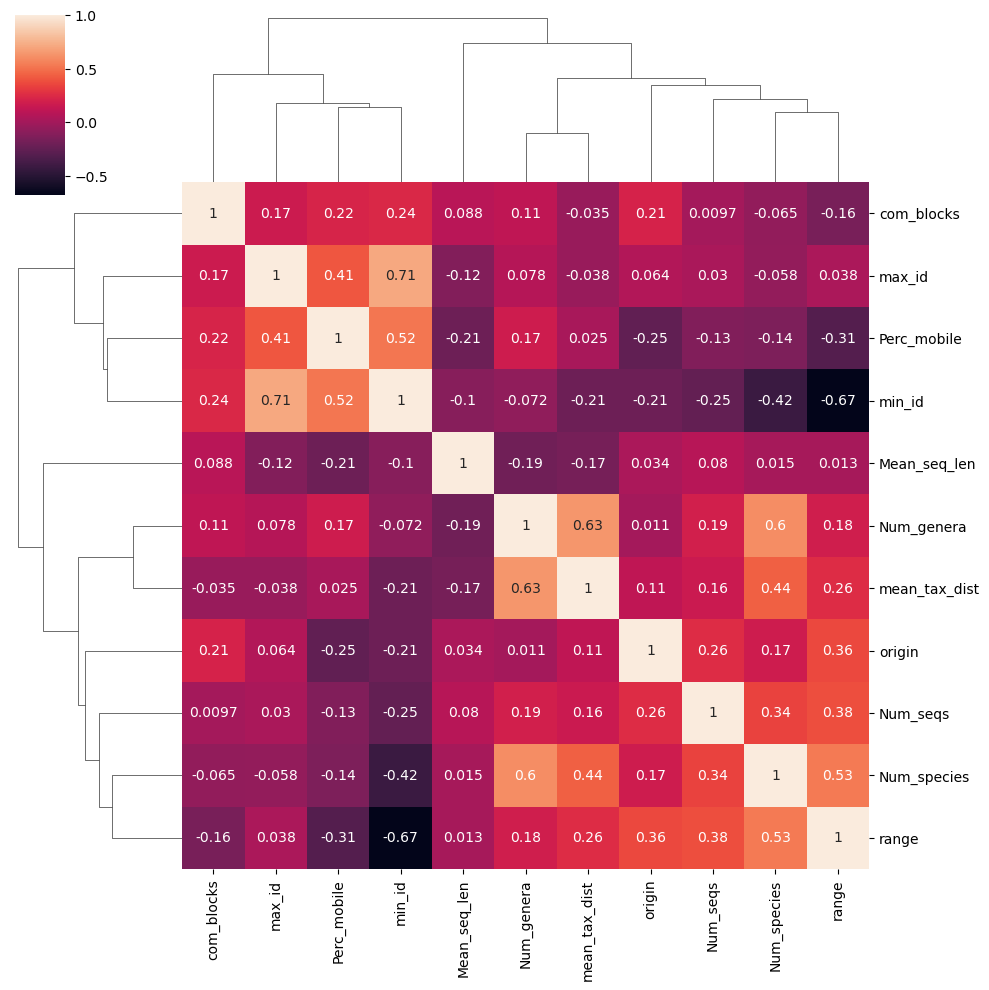

In [29]:
#See how/whether the features correlate - If they correlate some may have to be removed
sns.clustermap(feature_frame.corr(), annot=True)

We see that Num genera and mean_tax_dist are highly correlated. Mean_tax_dist contains more useful information as it is not as sensitive to outliers and misclassifications as Num_genera/Num_species, therefore we will drop Num_genera/Num_species. We also see that Num_seqs is one of the variables that is more correlated to the origin variable - but this may be misleading 
, as some of the origins in the training data are species that have been sequenced extensively. This is unlikwly to be the case for all origins, so we drop Num_seqs too.

In [30]:
#Drop Num_seqs and Num_genera
#Split dataframe into data to train the model on and data to be labeled later. All rows that have 'NaN' in the origin column are to be predicted later
df.drop(['Num_seqs', 'Num_genera', 'Num_species'], axis=1, inplace=True)

df_train=df.dropna()
df_pred=df[df['origin'].isna()]

features=df_train[[c for c in df.columns if not c=='origin']].to_numpy()
target=df_train['origin'].to_numpy().reshape(-1, 1).ravel()

In [31]:
pre_rfc=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=50)

#Do this 100 times to get distributions of feature importances
importances=[]
for i in range(100):

    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, stratify=target)

    pre_rfc.fit(x_train, y_train)
    importances.append(pre_rfc.feature_importances_)

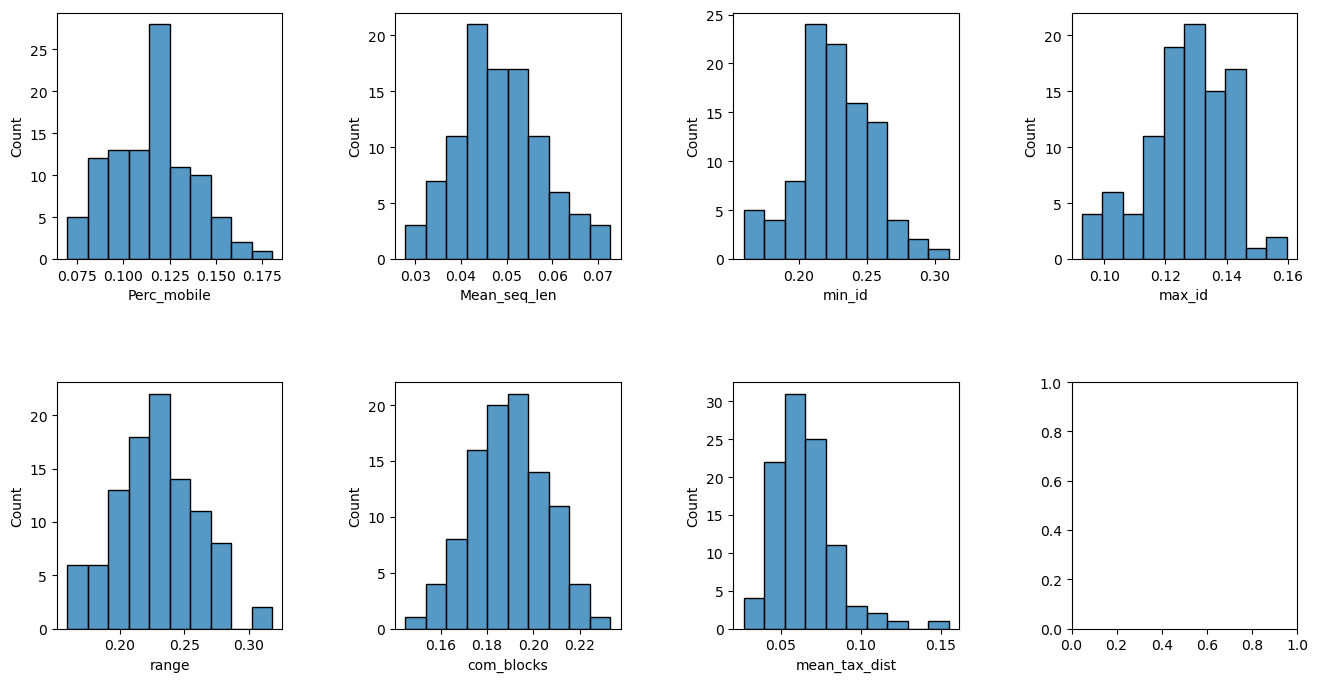

In [32]:
#Convert importances to dataframe and plot distributions
imp_df=pd.DataFrame(importances, columns=[c for c in df.columns if not c=='origin'])

fig, axes = plt.subplots(2, 4, figsize=[16,8])
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for ax, c in zip(axes.flatten(), [c for c in imp_df.columns]):
    sns.histplot(imp_df[c], bins=int(np.sqrt(len(imp_df))), ax=ax)

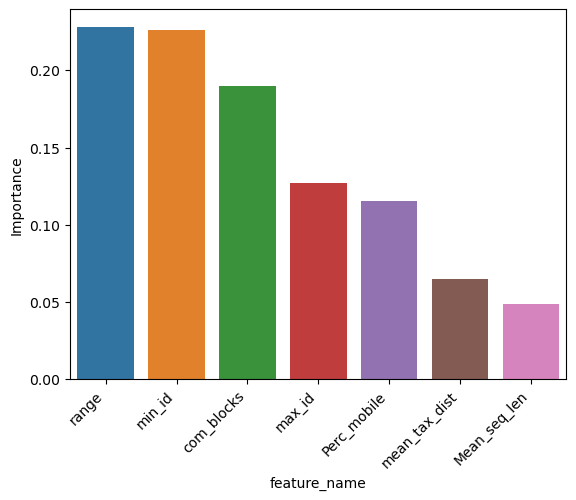

In [33]:
#Plot feature importances
imps=pd.Series([imp_df[c].mean() for c in imp_df.columns])
cols=pd.Series([c for c in imp_df.columns])

featimp_df=pd.DataFrame({'Importance':imps, 'feature_name':cols}).sort_values(by='Importance', ascending=False)

ax=sns.barplot(data=featimp_df, x='feature_name', y='Importance')
labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=45, ha='right')

plt.show()

Mean_seq_len is least important, so we drop the feature before we train the final model.

### Classifier training and validation 

In [34]:
#Train random forest classifier - Random forest classifier does not need normalized/standardized data, 
#so data can be input as is

#Select final features:
features=df_train[['min_id', 'range', 'com_blocks', 'max_id', 'Perc_mobile', 'mean_tax_dist']].to_numpy()

#Split training data into train/test data
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, stratify=target, random_state=2)

rfc=RandomForestClassifier(random_state=2, class_weight='balanced_subsample')

#Do a grid search to find best parameters
param_grid=[
    {'n_estimators':[50, 100, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    'min_samples_split' : [2, 3, 4, 5, 6],
    'max_leaf_nodes' : [5, 10, 15, 20, 30]
    }]

rfc_CV=GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, n_jobs=-1)
rfc_CV.fit(x_train, y_train)

params=rfc_CV.best_params_
print(f'Best parameters: {params}')

Best parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': 20, 'min_samples_split': 2, 'n_estimators': 50}


In [35]:
#Extract best estimator from grid search
rfc_best=rfc_CV.best_estimator_

#### LOOCV (Leave-one-out cross validation)

As the number of positive cases (origins) in our training dataset is low, k-fold cross validation with test set sizes >10% removes positive cases from the training data and thus may underestimate the classifiers predictive capabilities. To my knowledge, it is not possible to calculate evaluation metrics as precison and recall from scikit-learn's LOOCV class, so we write our own LOOCV function and calculate our metrics from that.

In [36]:
#Write own LOOCV function in order to extract metrics like precision and recall based on LOOCV of the whole dataset
def loocv(df_train, features, target):

    #Define confusion matrix 
    tn=0
    tp=0
    fn=0
    fp=0

    #iteratively form LOOCV training and test sets
    for i, element in enumerate(features):
        loo_feats_train=np.delete(features, i, axis=0)
        loo_target_train=np.delete(target, i, axis=0).reshape(-1, 1).ravel()

        loo_feats_test=features[i].reshape(1, -1)
        loo_target_test=target[i].reshape(-1, 1).ravel()

        #train random forest classifier
        rfc_best.fit(loo_feats_train, loo_target_train)
        pred=rfc_best.predict(loo_feats_test)

        if loo_target_test[0]==1:
            if pred[0]==loo_target_test[0]:
                tp+=1
            else:
                fn+=1
        elif loo_target_test[0]==0:
            if pred[0]==loo_target_test[0]:
                tn+=1
            else:
                fn+=1

    #calculate precision and recall
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    accuracy=(tp+tn)/(tp+tn+fp+fn)
    specificity=tn/(tn+fp)
    balanced_accuracy=(recall+specificity)/2

    return (precision, recall, accuracy, specificity, balanced_accuracy)    

In [37]:
#perform LOOCV and print evaluation metrics
precision, recall, accuracy, specificity, balanced_accuracy = loocv(df_train, features, target)

print('Random Forest Classifier Leave-one-out cross validation metrics: ') 
print(f'Accuracy: {round(accuracy,2)}')
print(f'Balanced accuracy: {round(balanced_accuracy, 2)}')
print(f'Precision: {round(precision, 2)}')
print(f'Recall: {round(recall, 2)}')
print(f'Specificity: {round(specificity, 2)}')

Random Forest Classifier Leave-one-out cross validation metrics: 
Accuracy: 0.98
Balanced accuracy: 0.88
Precision: 1.0
Recall: 0.75
Specificity: 1.0


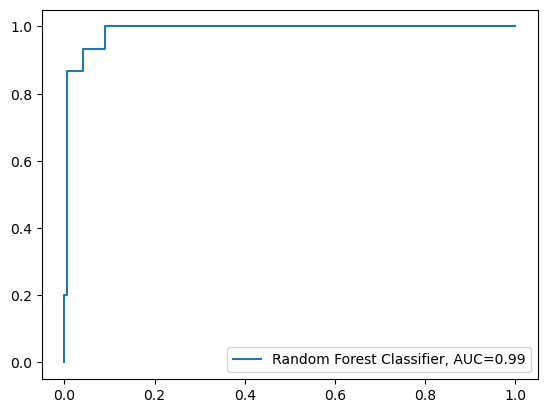

In [38]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Plot ROC curve
rfc_best.fit(x_train, y_train)
rfc3_y_pred=rfc_best.predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, rfc3_y_pred)
auc = round(roc_auc_score(y_test, rfc3_y_pred),2)
plt.plot(fpr, tpr, label=f'Random Forest Classifier, AUC={auc}')


plt.legend()

### Predict novel origins

In this section we use the trained classifier to make predictions for each unlabeled block of sequences. Then we create a list of unique ARG groups for which an origin was predicted

In [39]:
#Use Random Forest classifier to predict novel origins
df_o=df_o[df_o['origin'].isna()]
df_o.drop('origin', axis=1, inplace=True)
df_o.dropna(inplace=True)

new_features=df_o[['min_id', 'range', 'com_blocks', 'max_id', 'Perc_mobile', 'mean_tax_dist']].dropna().to_numpy()

df_o['origin_prediction']=rfc_best.predict(new_features)

In [40]:
#Print unique predictions
new_origins=df_o[df_o['origin_prediction']==1]['Gene']
new_origins=new_origins.apply(lambda x: x.split('_contexts')[0])
new_origins.unique()

array(['aac2_-ia', 'aac3-iie', 'aac6_-iak', 'aac6_-ian', 'aac6_-ic',
       'aac6_ie_aph2_ia', 'aac6_-if', 'aac6_-ig', 'aac6_-ii', 'aac6_-iid',
       'aac6_-iih', 'aac6_-iy', 'aac6_-iz', 'aad6', 'adc-116', 'ant6-ia',
       'aph2__-if', 'aph2__-iia', 'aph3_-ia', 'aph3__-ib', 'aph3_-iib',
       'aph3_-iiia', 'aph3_-vi', 'aph6-id', 'aph7__-ia', 'bciii',
       'carb-9', 'catb9', 'cati', 'catiii', 'cbut_catb', 'ccol_act_chl',
       'cepa-44', 'cfxa6', 'cmh-4', 'cmy-59', 'cpha5', 'ctx-m-3',
       'dfra31', 'dfrg', 'ecol_catii', 'ermb', 'ermf', 'ermg', 'ermx',
       'flor', 'fona-4', 'fosa2', 'fosa6', 'fosa7', 'fosb2', 'fusb',
       'fusc', 'hera-3', 'imi-2', 'kluc-5', 'lnua', 'lnuc', 'lsaa',
       'lsab', 'lsae', 'mcr-3.2', 'meca', 'mel', 'mphb', 'mphc', 'mphe',
       'msra', 'nimb', 'och-6', 'olec', 'optra', 'oqxa-0', 'oqxa-1',
       'oqxb-0', 'oqxb-1', 'oxa-114g', 'oxa-129', 'oxa-22', 'oxa-29',
       'oxa-422', 'oxa-459', 'oxa-551', 'oxa-571', 'oxa-60', 'oxa-726',
       'oxa-9

In [41]:
#Remove args with known origins which were excluded from the training set due to the origin not being part of the block
known=['cmy-59', 'ctx-m-3', 'fosa2', 'fosa6', 'oqxa-0', 'oqxa-1', 'oqxb-0', 'oqxb-1', 'aph3_-vi']
no2=[i for i in new_origins.unique() if not i in known]
print(f'Number of ARG groups with predicted origin: {len(no2)}')

Number of ARG groups with predicted origin: 123


#### Removal of ARG groups being hosted by gram positives

Manual analysis of the above predicted genes has shown that it is very difficult to classify some sequences originating from gram-positives as mobile or non-mobile. In order to avoid false positive origin suggestions, we remove ARG groups that are to a large extent harbored by gram positive species. 

In [42]:
#Now remove those that are mainly carried by gram positives

#Extract needed columns and drop all rows that represent an outgroup block - these useually have short seqs from weird taxa, unclear weather taxonomy is correct 
sub_df=df_o.copy(deep=True)
sub_df=df_o[['Gene', 'Genera', 'Block']]
pos=sub_df[sub_df['Block']!='BlockO'].drop(['Block'], axis=1).groupby('Gene')

#Get list of taxa for all blocks of each gene family
tax_dict={name:set(','.join(list(group['Genera'].values)).split(',')) for name, group in pos}

#Define list of gram-positive taxa
gram_positives = ['Actinomyces','Plantactinospora','Urinicoccus','Metabacillus','Cytobacillus','Domibacillus','Priestia','Sutcliffiella','Limosilactobacillus','Nosocomiicoccus','Actinotignum','Cutibacterium','Schaalia','Pseudoglutamicibacter','Aeromicrobium','Saccharopolyspora','Solobacterium','Robertmurraya','Treponema','Facklamia','Blautia','Eggerthella','Collinsella','Butyricicoccus','Lactonifactor','Gracilibacillus','Absiella','Prescotella','Margalitia','Ligilactobacillus','Siminovitchia','Paenarthrobacter','Virgibacillus','Ruania','Arthrobacter','Plantibacter','Glutamicibacter','Tessaracoccus','Sporosarcina','Brevibacillus','Microtetraspora','Heyndrickxia', 'Mammaliicoccus','Clostridioides','Anaerosporobacter','Tissierellia','Kallipyga','Rothia','Eisenbergiella','Flavonifractor','Mycolicibacterium', 'Lysinibacillus', 'Micromonospora', 'Faecalicatena', 'Gordinibacter',  'Aerococcus',    'Arthrobacter',    'Atopobium',    'Bacillus',    'Bifidobacterium',    'Brevibacterium',    'Butyrivibrio',    'Carnobacterium',    'Cellulomonas',    'Clostridium',    'Collinsella',    'Coprococcus',    'Corynebacterium',    'Desulfotomaculum', 'Enterococcus',   'Erysipelothrix',    'Eubacterium',    'Exiguobacterium',    'Finegoldia',    'Gardnerella',    'Geobacillus',    'Lachnospira',    'Lactobacillus',    'Lactococcus',    'Leifsonia',    'Listeria',    'Macrococcus', 'Microbacterium',    'Micrococcus',    'Mogibacterium',    'Mycobacterium',    'Nocardia',  'Paenibacillus',    'Peptococcus',    'Peptostreptococcus',    'Planococcus',    'Propionibacterium',    'Pseudoclavibacter',    'Rhodococcus',    'Ruminococcus',    'Sarcina',    'Scardovia',    'Slackia',    'Solibacillus',    'Staphylococcus',    'Streptococcus',    'Streptomyces',    'Terrisporobacter',    'Thermoactinomyces',    'Thermobifida', 'Trueperella',    'Turicibacter',    'Vagococcus',  'Weissella']

#calculate percentage of gram positive genera for each gene family
perc_pos={key: len([i for i in value if i in set(gram_positives)])/len(value) for key, value in tax_dict.items() if key.replace('_contexts', '') in no2}

#Retain only those args where < 40% of hosts are gram-positive
filtered=[key.replace('_contexts', '') for key in perc_pos.keys() if perc_pos[key]<0.4]

print(f'Number of ARG groups with predicted origin after removal of gram-positive-associated ARGs: {len(filtered)}')

Number of ARG groups with predicted origin after removal of gram-positive-associated ARGs: 86
